# Проект 9

In [1]:
!pip install scanpy[leiden] scrublet harmonypy symphonypy bbknn anndata

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.8 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=8f62e6e46b2f2ee448e55acad93caca242a49aec3ca70611848f977572da2d88
  Stored in directory: /root/.cache/pip/wheels/64/

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce
import symphonypy as sp
import bbknn

sns.set_style("ticks")
sc.settings.verbosity = 3
sc.set_figure_params(dpi=150)

## Загрузка датасета

In [3]:
!gdown '118dVUszFtugVm-UqZaVrY6zqPwVYsCkT'

Downloading...
From: https://drive.google.com/uc?id=118dVUszFtugVm-UqZaVrY6zqPwVYsCkT
To: /content/adata.h5ad
100% 79.3M/79.3M [00:00<00:00, 89.1MB/s]


In [4]:
# Прочитываем датасет
adata_bmmc = sc.read_h5ad("adata.h5ad")

In [5]:
print(adata_bmmc)

AnnData object with n_obs × n_vars = 6106 × 13953
    obs: 'cell_type'
    var: 'feature_types', 'gene_id'


### Контроль качества и препроцессинг

In [6]:
# Делаем гены датасета уникальными
adata_bmmc.var_names_make_unique()

In [7]:
adata_bmmc.X.max()

20816.0

In [8]:
# Таблица с аннотацией клеток
adata_bmmc.obs

,cell_type
CTATCCGGTGTCCGGT-1-s1d3,CD14+ Mono
AGAAGCGGTGTCTTAG-1-s1d3,CD8+ T naive
GGCTTGGTCTACGCAA-1-s1d3,NK
AGAAGTATCTAAGCCA-1-s1d3,CD8+ T naive
GAACGTTTCCTACGAA-1-s1d3,T reg
...,...
AACAAAGGTTGGTACT-1-s1d3,CD8+ T naive
TGACAGTCATGGCTGC-1-s1d3,CD8+ T CD57+ CD45RA+
CTGGCAGGTCTCACGG-1-s1d3,CD8+ T naive
GTAACCATCGGAGTGA-1-s1d3,Reticulocyte


In [9]:
adata_bmmc.obs.rename(columns={"cell_type": "cell.labels"}, inplace=True)
adata_bmmc.obs["organ"] = "BMMC"
adata_bmmc.obs

,cell.labels,organ
CTATCCGGTGTCCGGT-1-s1d3,CD14+ Mono,BMMC
AGAAGCGGTGTCTTAG-1-s1d3,CD8+ T naive,BMMC
GGCTTGGTCTACGCAA-1-s1d3,NK,BMMC
AGAAGTATCTAAGCCA-1-s1d3,CD8+ T naive,BMMC
GAACGTTTCCTACGAA-1-s1d3,T reg,BMMC
...,...,...
AACAAAGGTTGGTACT-1-s1d3,CD8+ T naive,BMMC
TGACAGTCATGGCTGC-1-s1d3,CD8+ T CD57+ CD45RA+,BMMC
CTGGCAGGTCTCACGG-1-s1d3,CD8+ T naive,BMMC
GTAACCATCGGAGTGA-1-s1d3,Reticulocyte,BMMC


In [10]:
categories = adata_bmmc.obs['cell.labels'].cat.categories
print(categories)

Index(['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T CD314+ CD45RA+', 'CD4+ T activated',
       'CD4+ T activated integrinB7+', 'CD4+ T naive', 'CD8+ T CD49f+',
       'CD8+ T CD57+ CD45RA+', 'CD8+ T CD69+ CD45RA+', 'CD8+ T CD69+ CD45RO+',
       'CD8+ T TIGIT+ CD45RA+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T naive',
       'CD14+ Mono', 'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC', 'ILC1',
       'Lymph prog', 'MAIT', 'MK/E prog', 'NK', 'Naive CD20+ B IGKC+',
       'Naive CD20+ B IGKC-', 'Normoblast', 'Plasma cell IGKC+',
       'Proerythroblast', 'Reticulocyte', 'T reg', 'Transitional B', 'cDC2',
       'dnT', 'gdT CD158b+', 'gdT TCRVD2+', 'pDC'],
      dtype='object')


В файле лежат необработанные данные, приступим к их обработке

In [11]:
# Вычисление QC-метрик

adata_bmmc.var["mt"] = adata_bmmc.var.index.str.startswith("MT-") # Определение митохондриальных генов
sc.pp.calculate_qc_metrics(adata_bmmc, qc_vars=["mt"], percent_top=None, inplace=True, log1p=False)

Посмотрим на данные

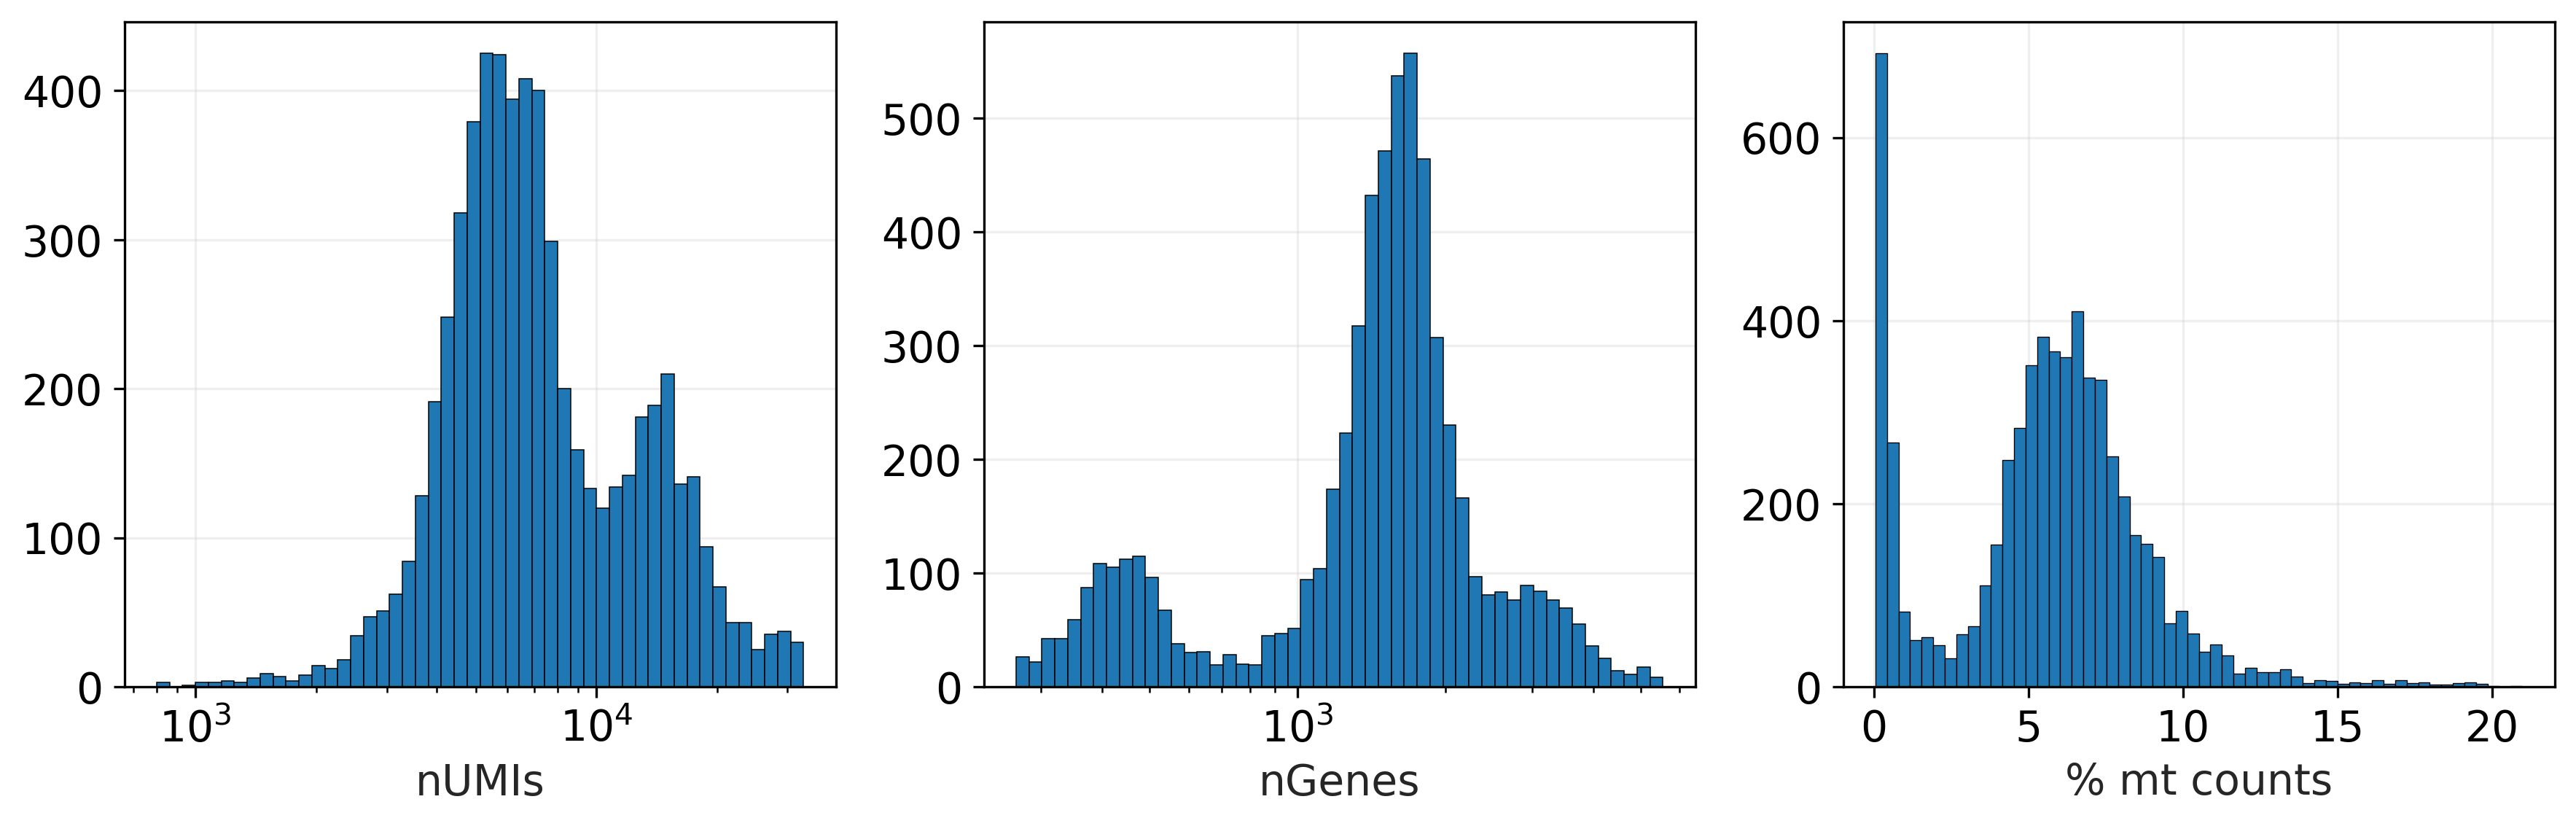

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(adata_bmmc.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_bmmc.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_bmmc.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [13]:
adata_bmmc = adata_bmmc[
    (adata_bmmc.obs.total_counts >= 2000) &
    (adata_bmmc.obs.n_genes_by_counts >= 900) &
    (adata_bmmc.obs.pct_counts_mt <= 20)
].copy()

In [14]:
# Идентификация и удаление doublets c помощью Scrublet

sc.pp.scrublet(adata_bmmc)
adata_bmmc = adata_bmmc[adata_bmmc.obs.doublet_score <= 0.2].copy()

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%
    Scrublet finished (0:01:41)


In [15]:
# Нормализация каунтов на клетку и логарифмирование

sc.pp.normalize_total(adata_bmmc, target_sum=1e4)
sc.pp.log1p(adata_bmmc)

normalizing counts per cell
    finished (0:00:00)


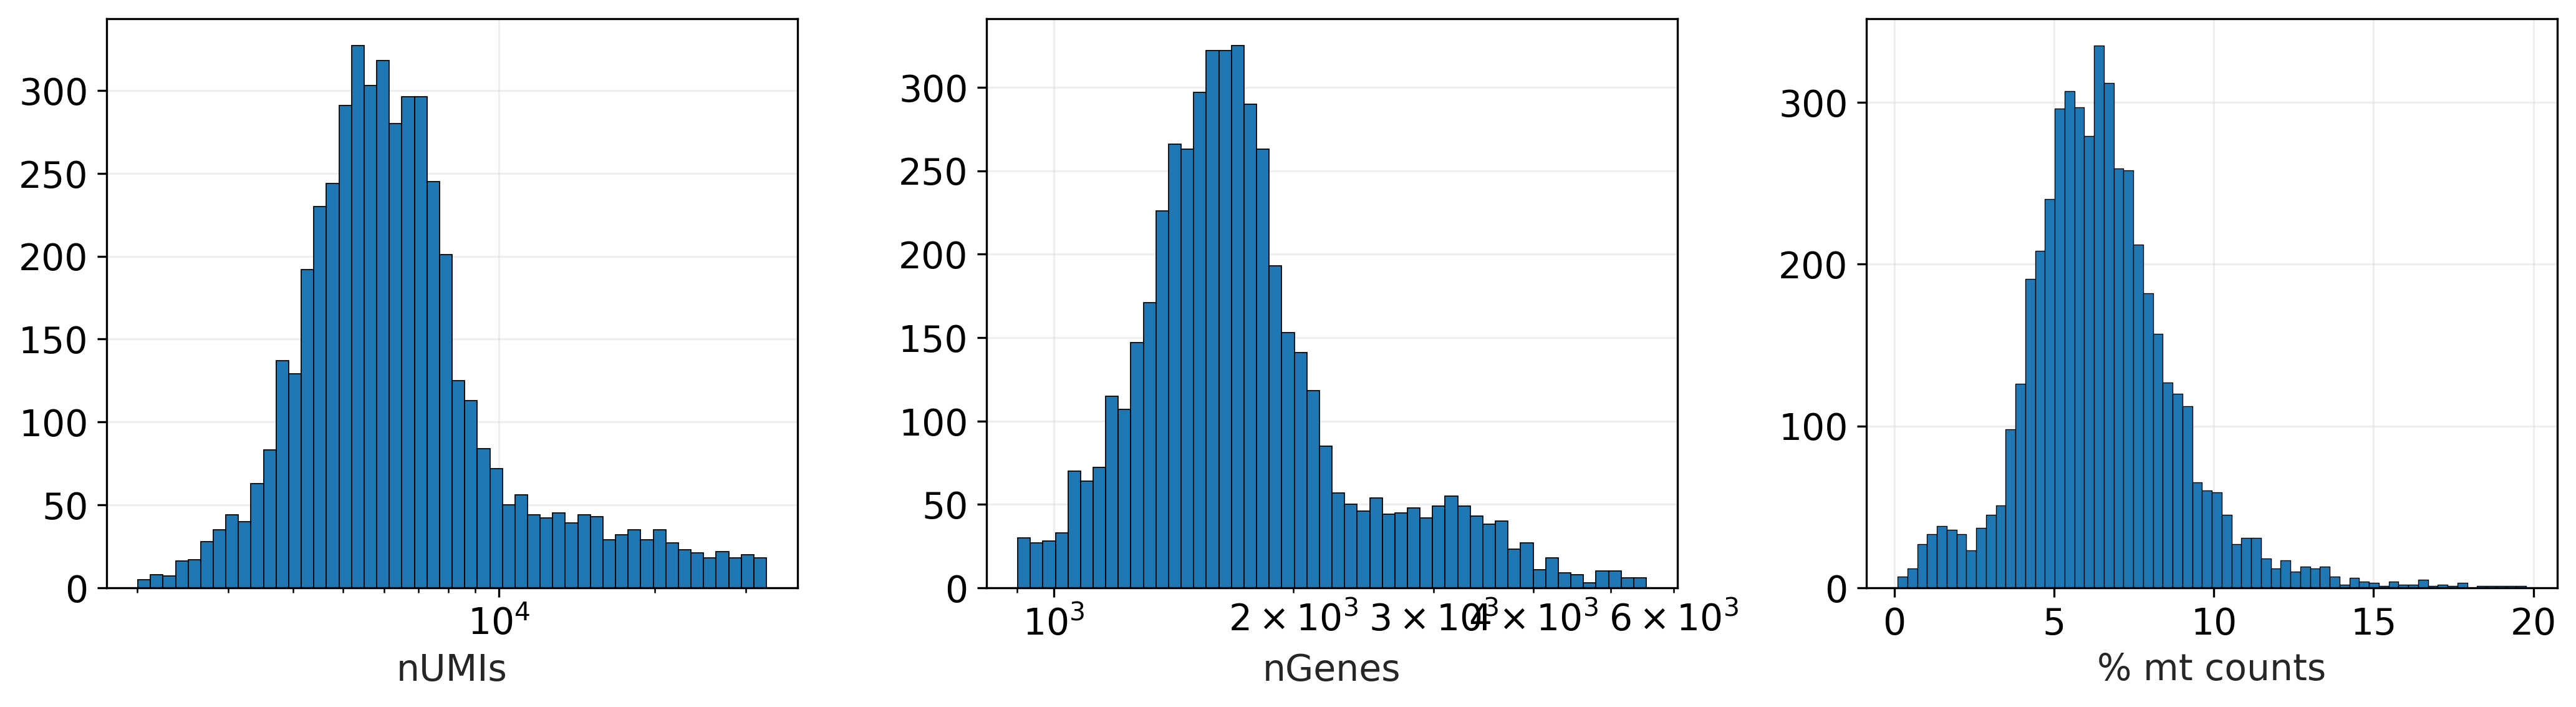

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

sns.histplot(adata_bmmc.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_bmmc.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_bmmc.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [17]:
# Выберем 3000 высоковариабельных генов (HVG)

sc.pp.highly_variable_genes(adata_bmmc, n_top_genes=3000)

# Saving the dataset in adata.raw
adata_bmmc.raw = adata_bmmc

adata_bmmc = adata_bmmc[:, adata_bmmc.var.highly_variable].copy()

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
# Saving the dataset in adata.raw

adata_bmmc.raw = adata_bmmc

In [19]:
# Scaling and PCA

sc.pp.scale(adata_bmmc, max_value=10)
sc.pp.pca(adata_bmmc, n_comps=20)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=20
    finished (0:00:01)


In [20]:
# UMAP and clustering

sc.pp.neighbors(adata_bmmc, use_rep="X_pca")
sc.tl.umap(adata_bmmc, min_dist=0.3)
sc.tl.leiden(adata_bmmc)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
running Leiden clustering


<ipython-input-20-3a33e0e70da2>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_bmmc)


    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


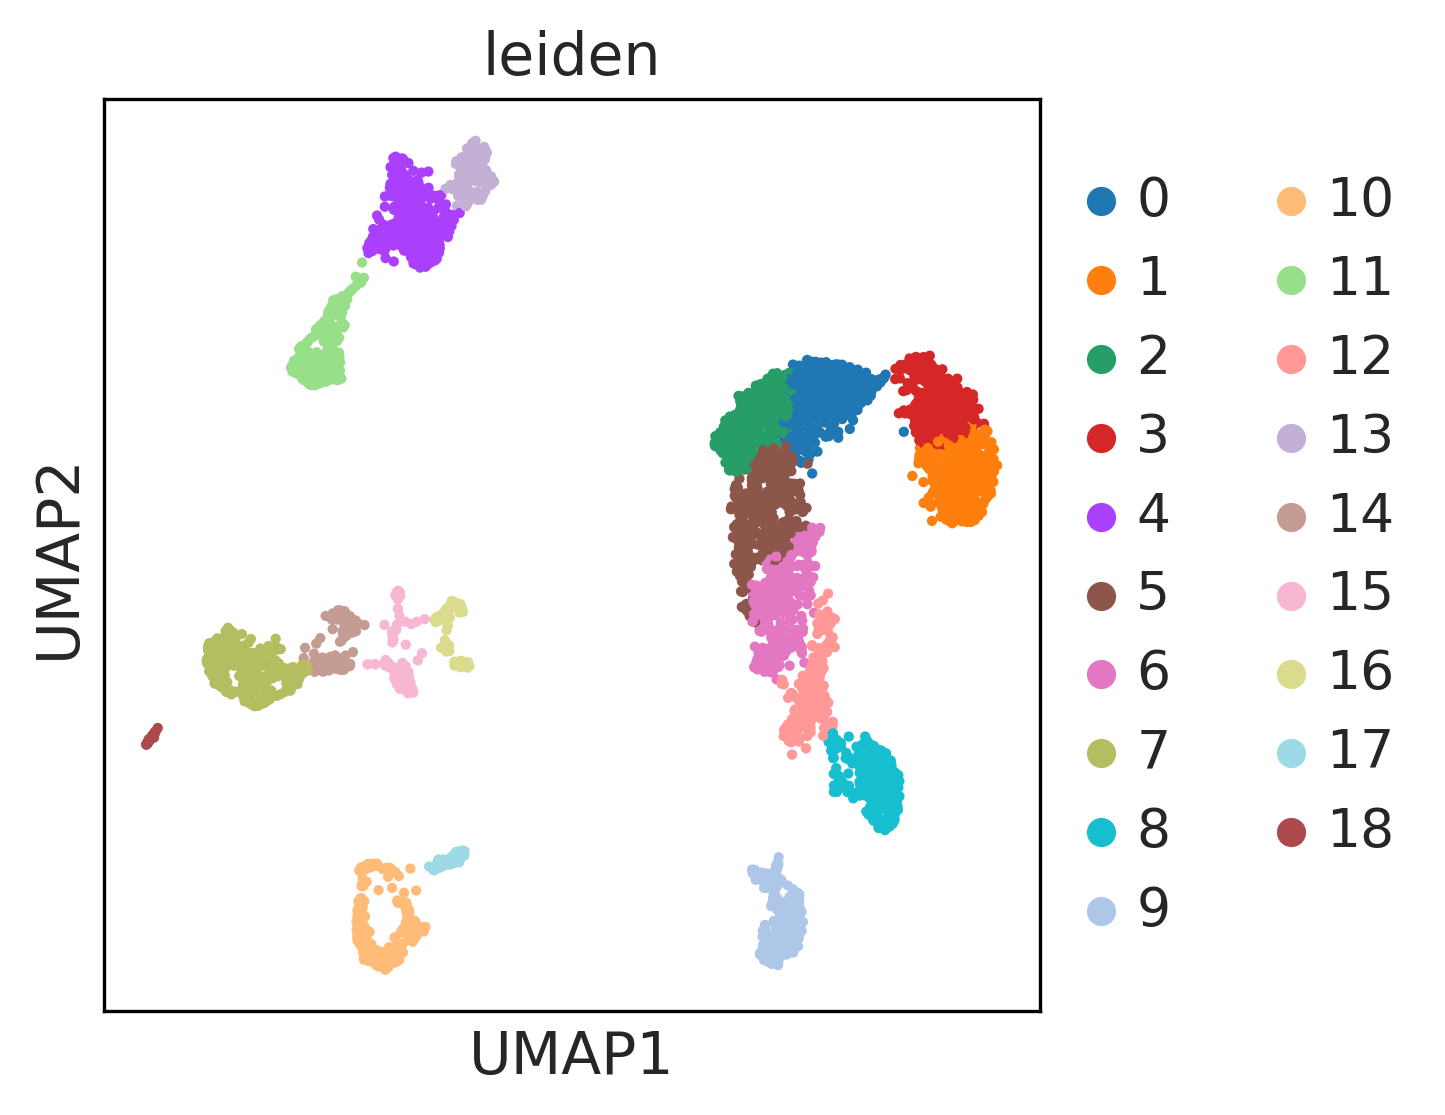

In [21]:
# Кластеризация и окрашивание по кластерам (leiden)
sc.pl.umap(adata_bmmc, color="leiden")

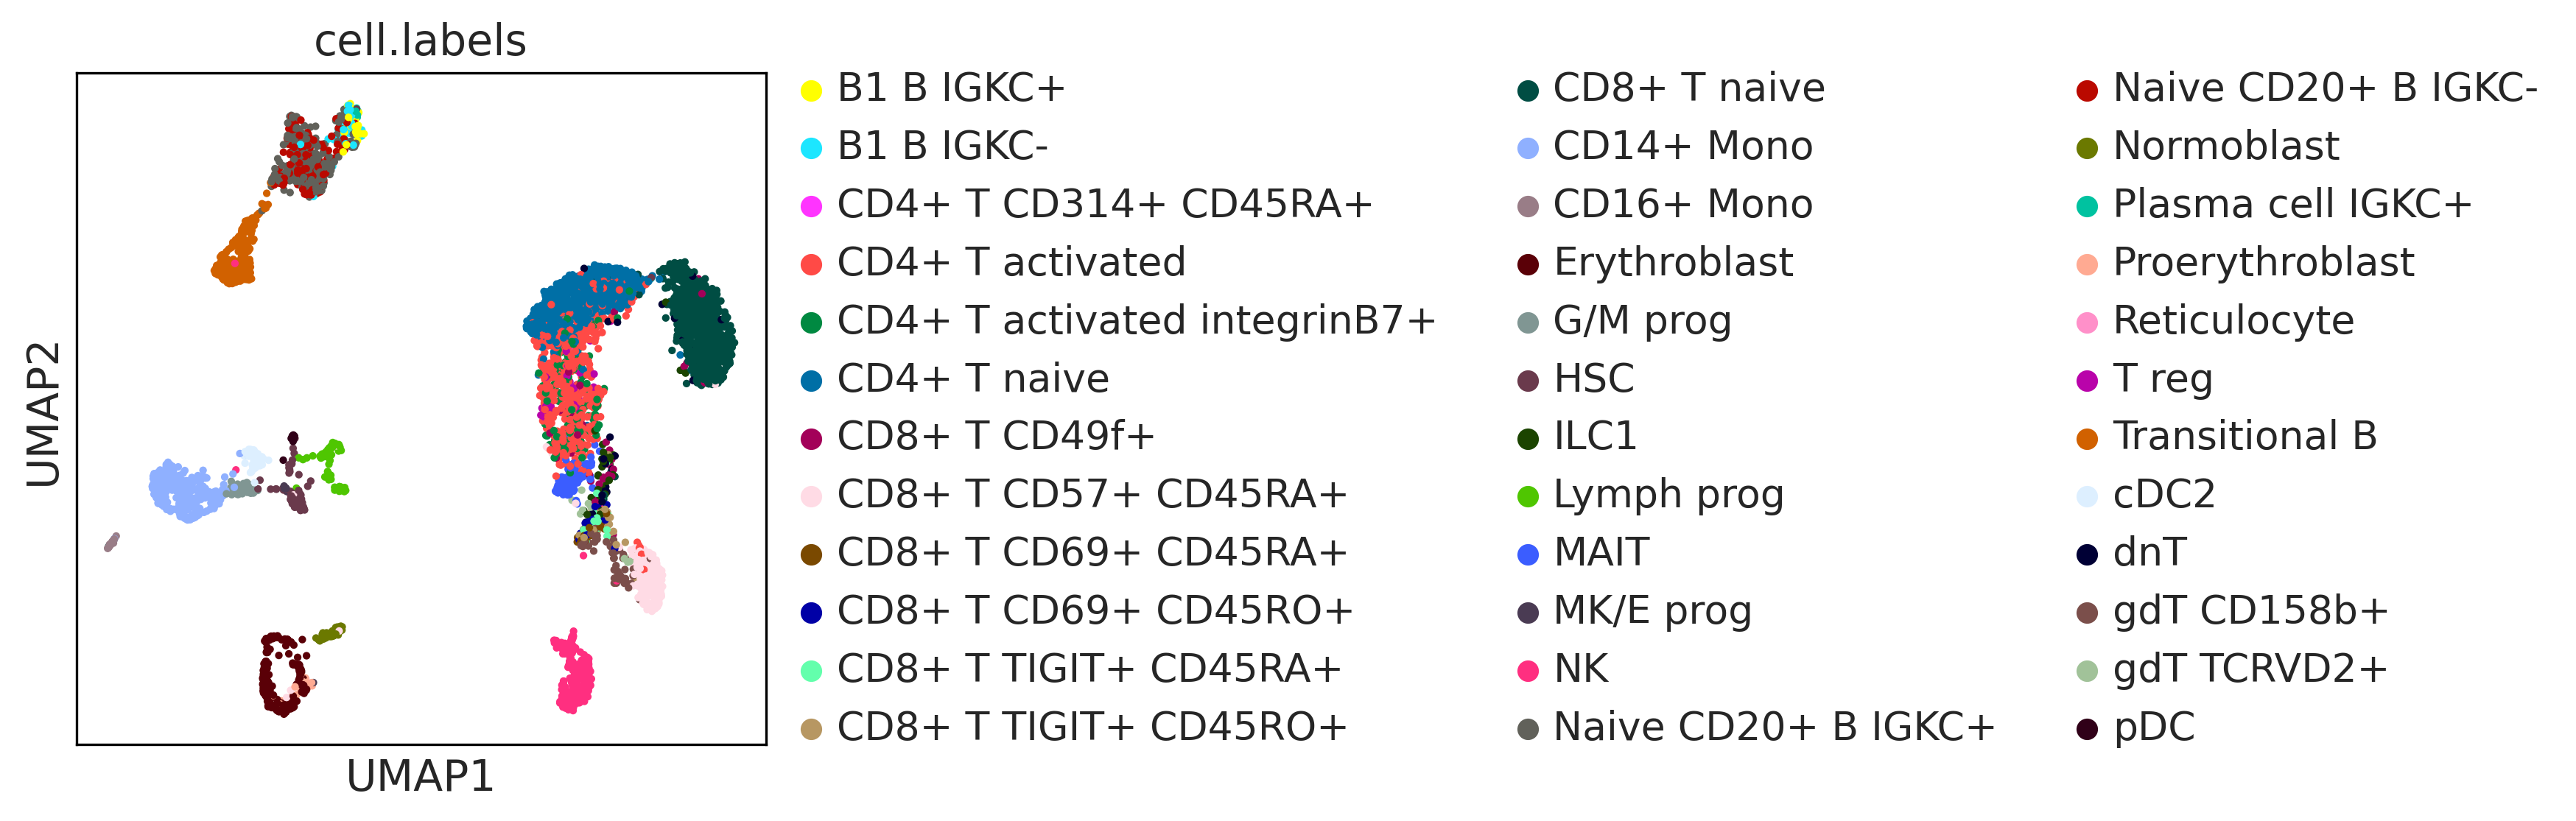

In [22]:
# Окрашивание по типам клеток (cell.labels)
sc.pl.umap(adata_bmmc, color="cell.labels")

# Автоматическая аннотация

In [23]:
import scanpy as sc
import symphonypy as sp
import anndata as ad

# Загрузка данных Fetal Liver Hematopoiesis Atlas через symphonypy
fetal_liver_data = sp.datasets.fetal_liver()

try downloading from url
https://zenodo.org/record/7607565/files/fetal_liver_reference_3p.h5ad
... this may take a while but only happens once
creating directory data/symphony_ref/ for saving data


  0%|          | 0.00/218M [00:00<?, ?B/s]

In [24]:
# взглянем на данные
print(fetal_liver_data.obs.columns)

Index(['cell.labels', 'organ', 'facs.sort', 'Source.Name', 'cell_barcode',
       'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'stages', 'gender',
       'doublets', 'combined.labels', 'batch', 'sample', 'donor', 'pcw',
       'donor_pcw'],
      dtype='object')


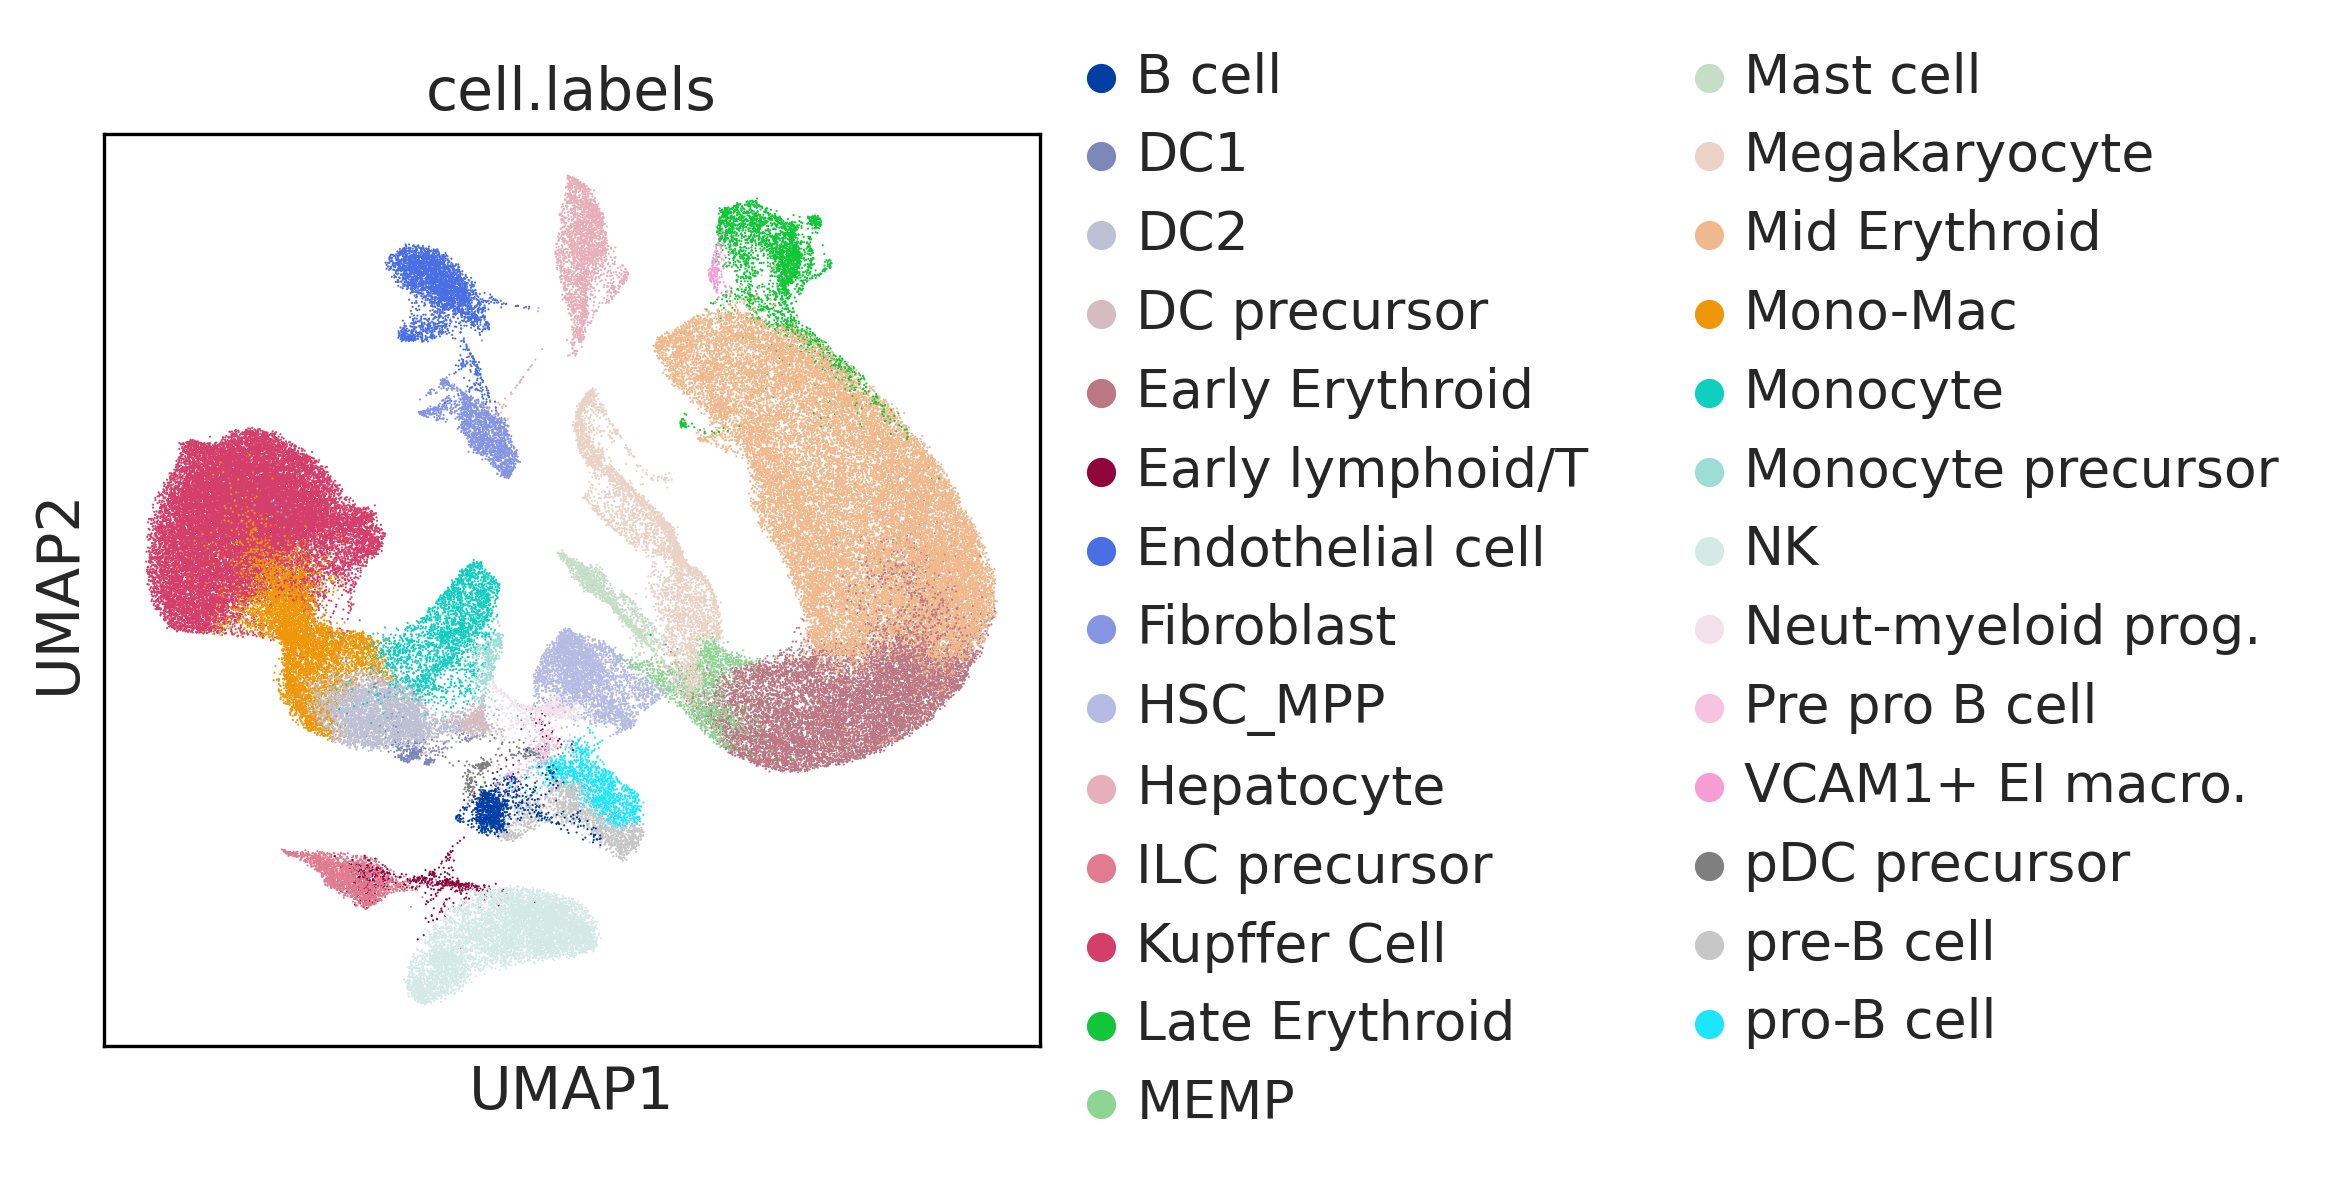

In [25]:
sc.pl.umap(fetal_liver_data, color="cell.labels") # проверка визуализации референса

In [26]:
adata_query = adata_bmmc.raw.to_adata()

In [27]:
sp.tl.map_embedding(adata_query, fetal_liver_data, key="organ")
sp.tl.per_cell_confidence(adata_query, fetal_liver_data)
sp.tl.transfer_labels_kNN(adata_query, fetal_liver_data, ref_labels=["cell.labels"])

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


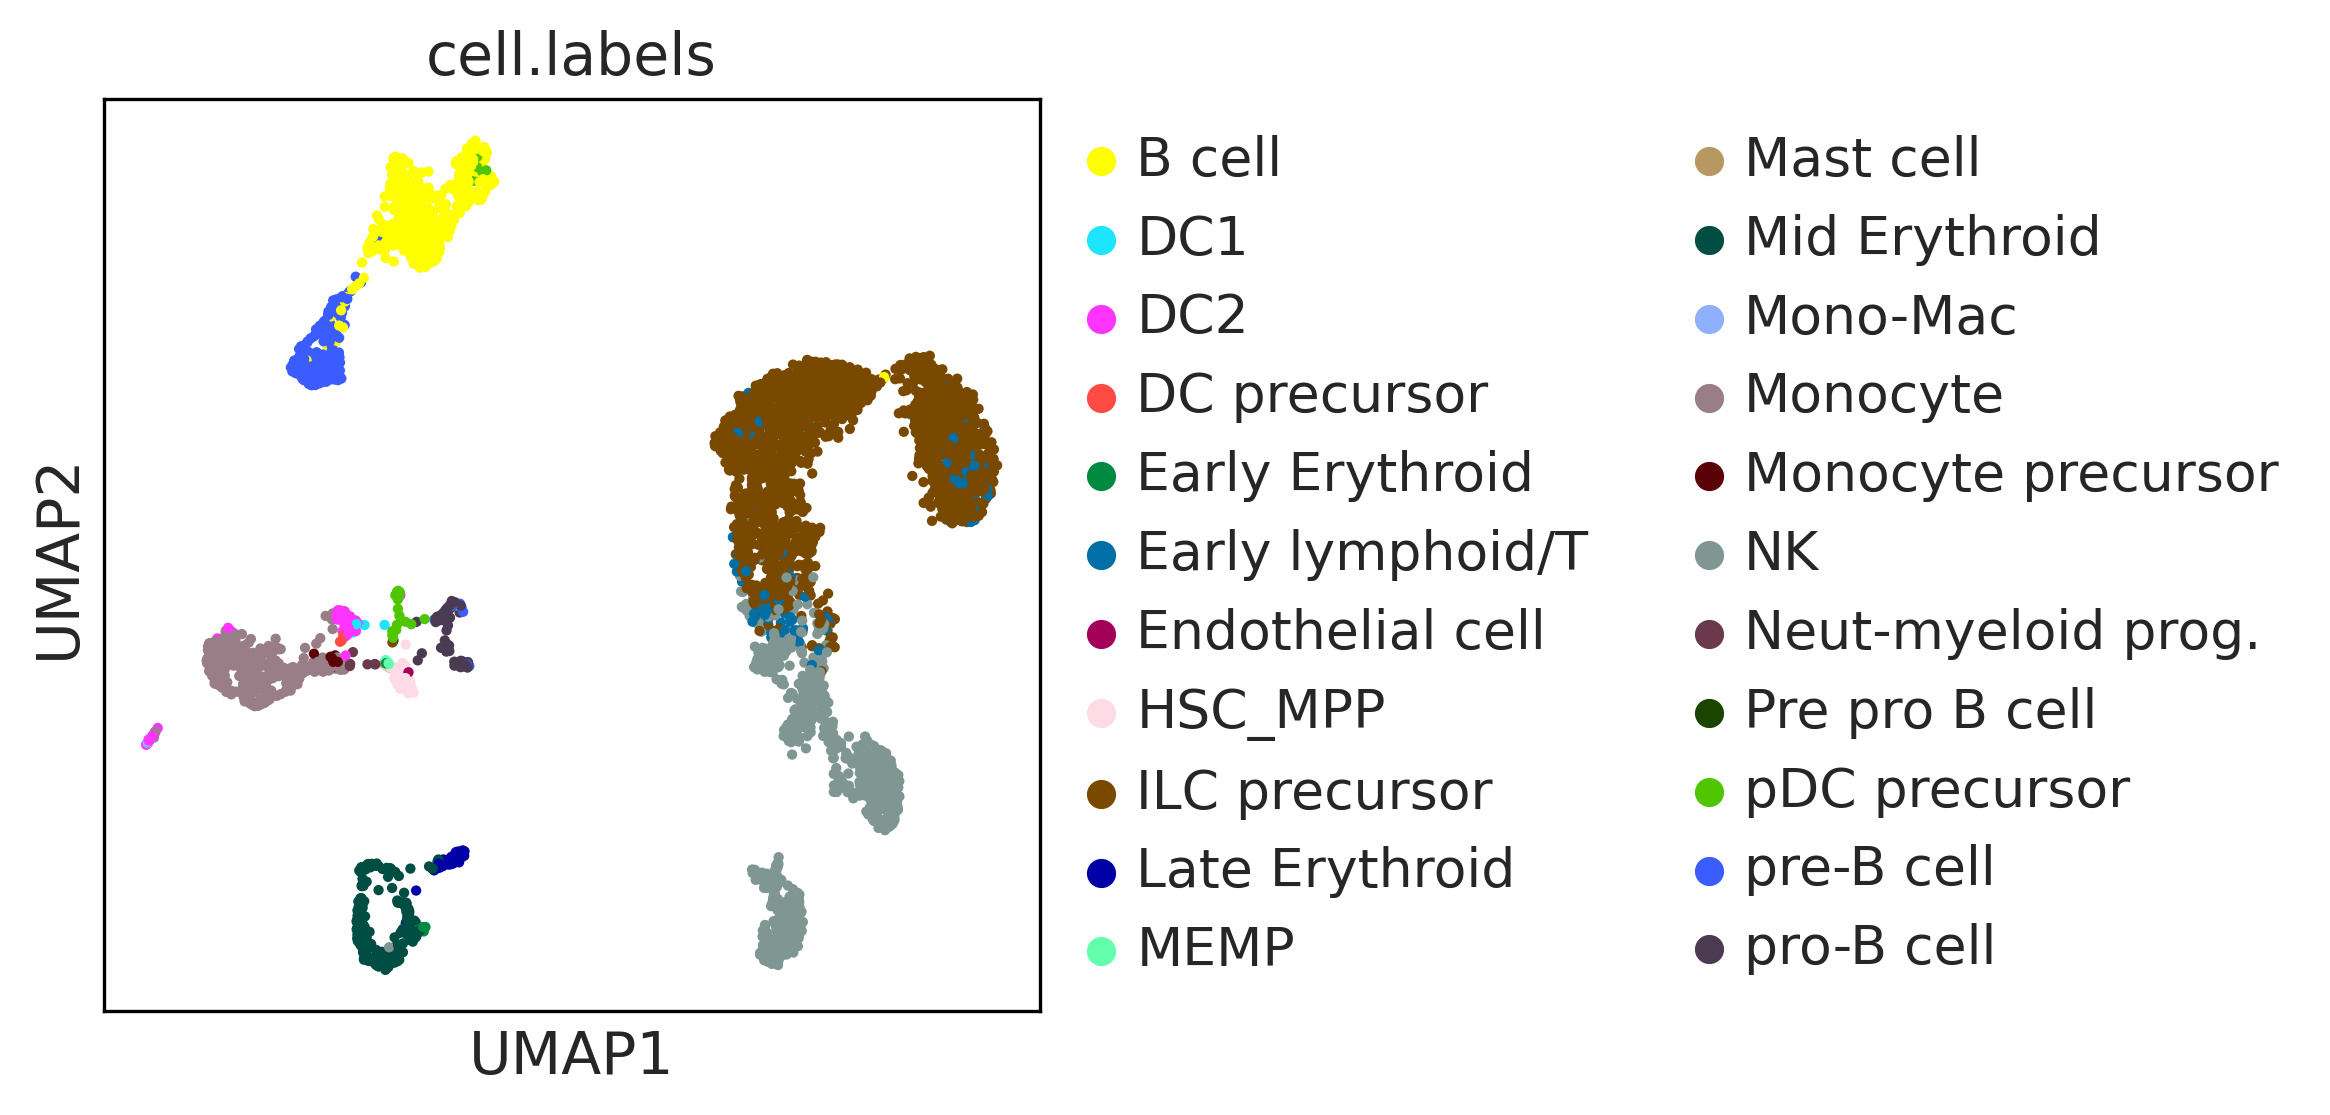

In [28]:
sc.pl.umap(adata_query, color="cell.labels")

In [29]:
adata_query_umap = adata_query.copy()
sp.tl.ingest(adata_query_umap, fetal_liver_data) # Перенос UMAP с референса на query

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/symphonypy/tools.py:250: FutureWarning: The specified parameters ('inplace',) are no longer positional. Please specify them like `inplace=True`
  return ing.to_adata(inplace)


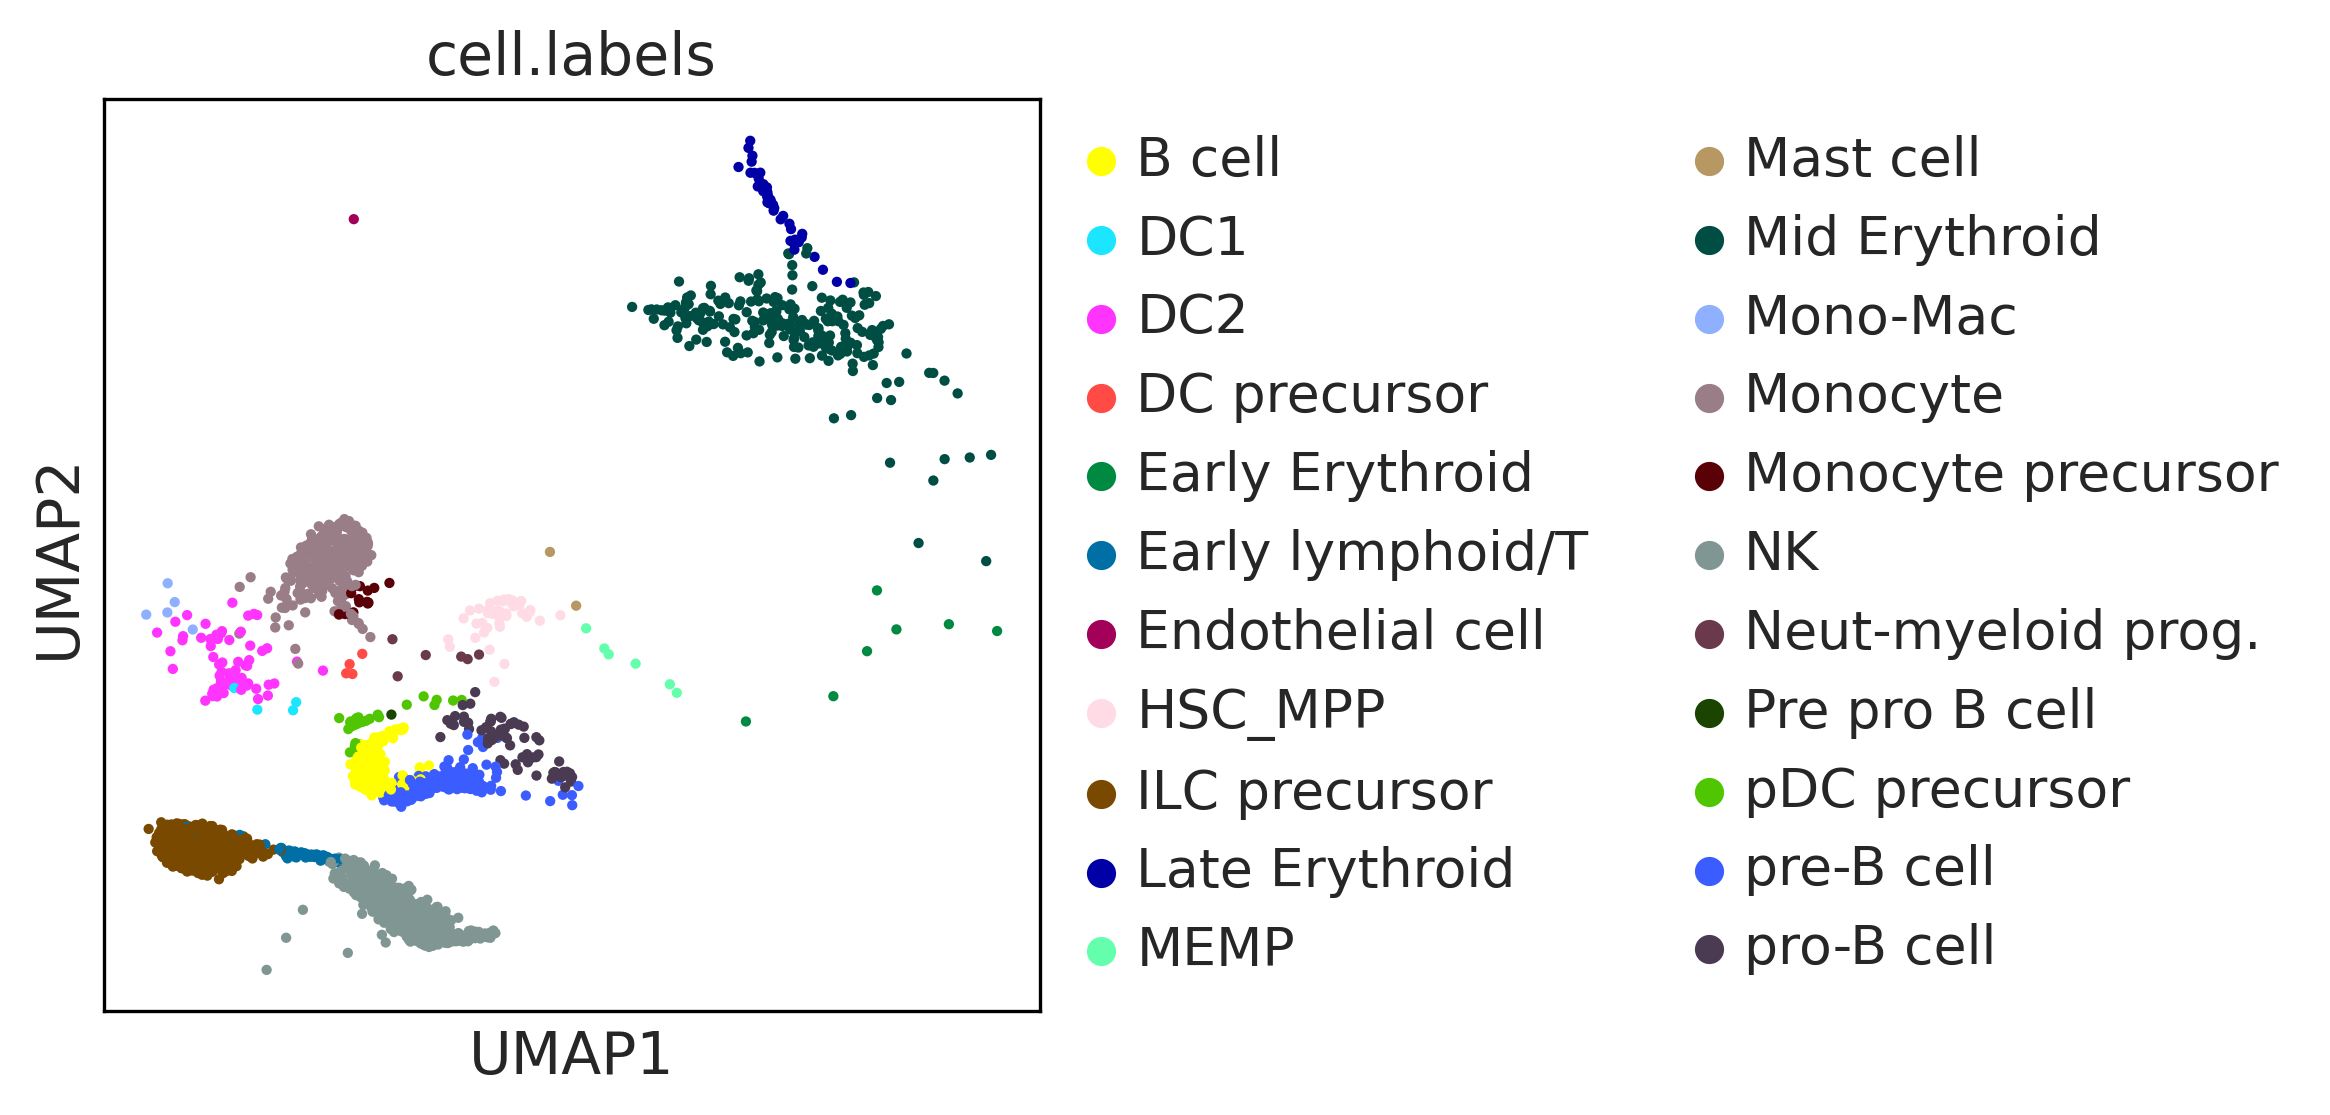

In [30]:
sc.pl.umap(adata_query_umap, color="cell.labels")

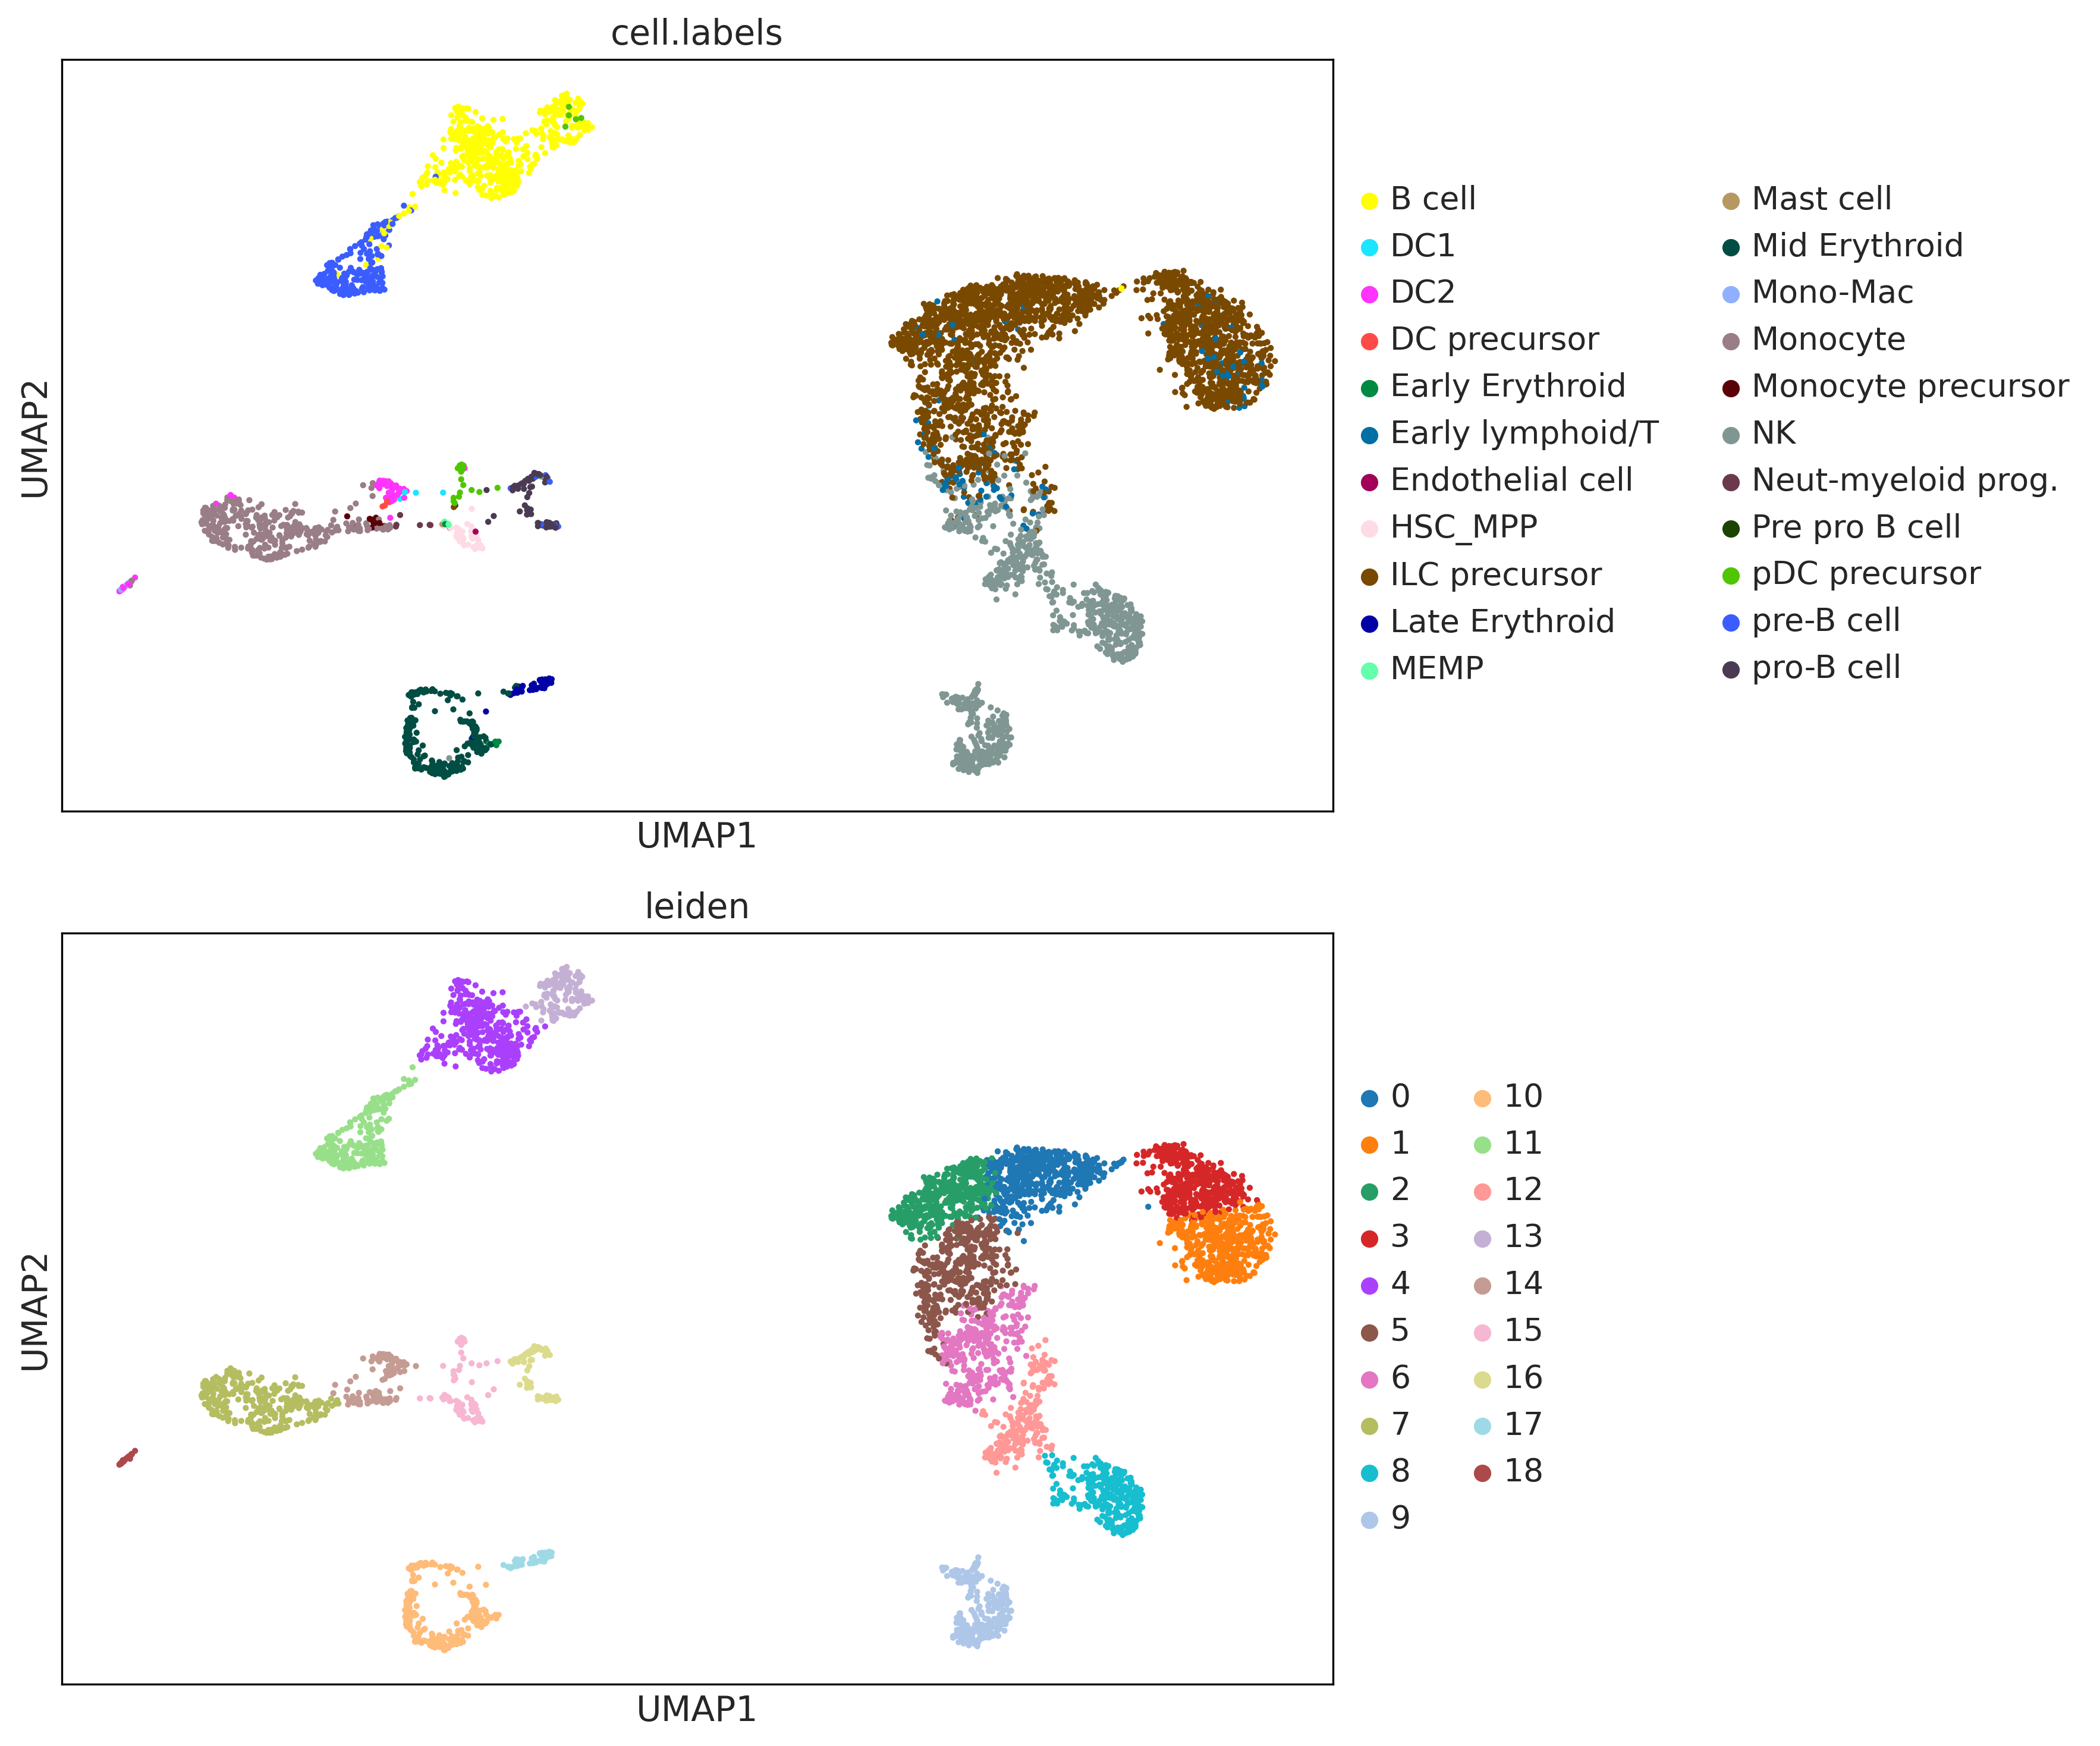

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Первый график - окрашивание по cell.labels
sc.pl.umap(adata_query, color="cell.labels", ax=axs[0], show=False)
axes[0].set_title("UMAP по типу клеток")

# Второй график - окрашивание по leiden
sc.pl.umap(adata_query, color="leiden", ax=axs[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

plt.tight_layout()
plt.show()